In [3]:
!pip install -q pandas numpy scikit-learn tensorflow transformers nltk spacy
!pip install -q langchain langchain-community langgraph fastapi uvicorn pyngrok nest_asyncio
!pip install -q datasets joblib matplotlib seaborn wordcloud pydantic

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 47.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 73.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.9/475.9 kB 42.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 4.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.32.4, but you have requests 2.32.5 which is incompatible.


In [4]:
import os
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

DATA LOADING AND CLEANING

In [5]:
import pandas as pd
import numpy as np
import re
from datasets import load_dataset
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split

# 1. Load Data (Subsample to 10k for speed as suggested in source 95)
print("Loading IMDB Dataset...")
dataset = load_dataset("imdb")
df = pd.DataFrame(dataset['train']).sample(10000, random_state=42) # 10k sample
test_df = pd.DataFrame(dataset['test']).sample(2000, random_state=42)

# 2. Preprocessing Function
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

def preprocess_text(text):
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Remove punctuation and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Tokenize and Lowercase
    words = text.lower().split()
    # Remove stopwords and stem
    words = [stemmer.stem(w) for w in words if w not in stop_words]
    return " ".join(words)

print("Preprocessing text... this may take a minute.")
df['cleaned_text'] = df['text'].apply(preprocess_text)
test_df['cleaned_text'] = test_df['text'].apply(preprocess_text)

print("Data Loaded and Cleaned.")

Loading IMDB Dataset...
Preprocessing text... this may take a minute.
Data Loaded and Cleaned.


EDA DATA ANALYSIS

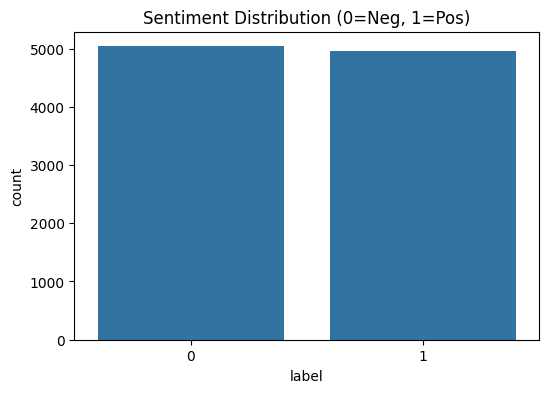

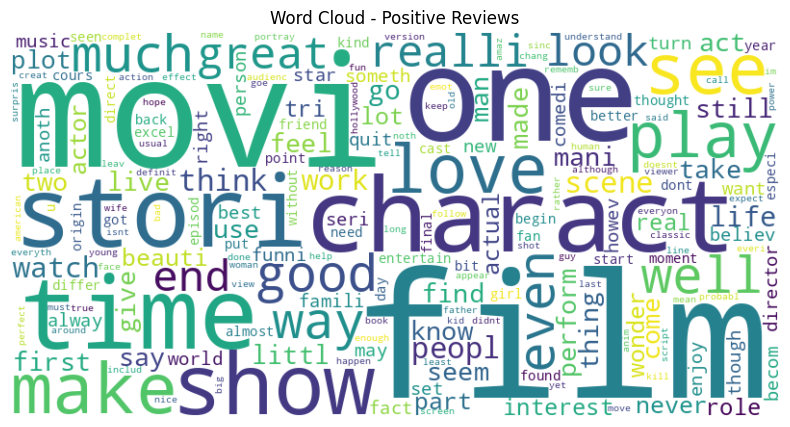

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Visualize Sentiment Distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='label', data=df)
plt.title("Sentiment Distribution (0=Neg, 1=Pos)")
plt.show()

# WordCloud for Positive Reviews
pos_text = " ".join(df[df['label'] == 1]['cleaned_text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(pos_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud - Positive Reviews")
plt.show()

LOGISTICS REGRESSION MODEL TRAINING

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
import joblib

# Vectorize
vectorizer = TfidfVectorizer(max_features=5000)
X_train = vectorizer.fit_transform(df['cleaned_text'])
X_test = vectorizer.transform(test_df['cleaned_text'])
y_train = df['label']
y_test = test_df['label']

# Train LogReg
model_lr = LogisticRegression()
model_lr.fit(X_train, y_train)

# Evaluate
preds = model_lr.predict(X_test)
print("Logistic Regression Accuracy:", accuracy_score(y_test, preds))
print(classification_report(y_test, preds))

# Save artifacts
joblib.dump(model_lr, 'src/models/model_lr.pkl')
joblib.dump(vectorizer, 'src/models/vectorizer.pkl')
print("Simple model saved.")

Logistic Regression Accuracy: 0.8665
              precision    recall  f1-score   support

           0       0.88      0.86      0.87      1040
           1       0.85      0.87      0.86       960

    accuracy                           0.87      2000
   macro avg       0.87      0.87      0.87      2000
weighted avg       0.87      0.87      0.87      2000

Simple model saved.


TRAINING ADVANCED LSTM MODEL

In [15]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.layers import Bidirectional


# Tokenize for Deep Learning
max_words = 10000
max_len = 100
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df['cleaned_text'])

X_train_seq = pad_sequences(tokenizer.texts_to_sequences(df['cleaned_text']), maxlen=max_len)
X_test_seq = pad_sequences(tokenizer.texts_to_sequences(test_df['cleaned_text']), maxlen=max_len)

# Build LSTM Model
model_lstm = Sequential([
    Embedding(max_words, 128, input_length=max_len),
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.3),
    LSTM(32),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])


model_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train (Epochs reduced to 3 for speed in Colab)
history = model_lstm.fit(X_train_seq, y_train, batch_size=32, epochs=10, validation_split=0.2)

# Save LSTM
model_lstm.save('src/models/model_lstm.h5')
joblib.dump(tokenizer, 'src/models/tokenizer.pkl')
print("Advanced model saved.")

Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.6510 - loss: 0.5866 - val_accuracy: 0.8410 - val_loss: 0.3794
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.9294 - loss: 0.2103 - val_accuracy: 0.8420 - val_loss: 0.4088
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.9706 - loss: 0.0998 - val_accuracy: 0.8185 - val_loss: 0.5646
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.9843 - loss: 0.0583 - val_accuracy: 0.8180 - val_loss: 0.5493
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.9889 - loss: 0.0411 - val_accuracy: 0.8255 - val_loss: 0.7366
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.9927 - loss: 0.0271 - val_accuracy: 0.8015 - val_loss: 0.7623
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.9849 - loss: 0.0468 - val_accuracy: 0.8110 - val_loss: 0.8050
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.9932 - loss: 0.0227 - val_accu

Advanced model saved.


EVALUATION AND RESULTS

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


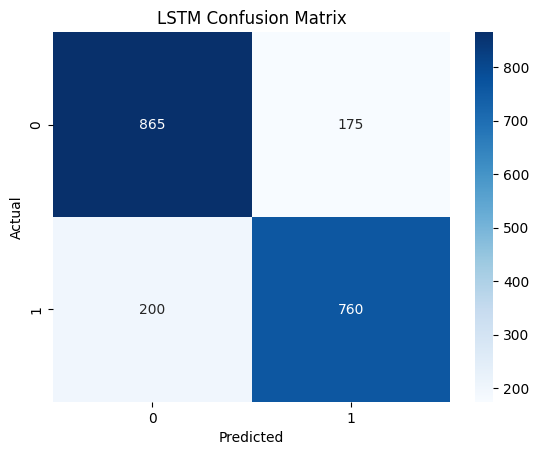

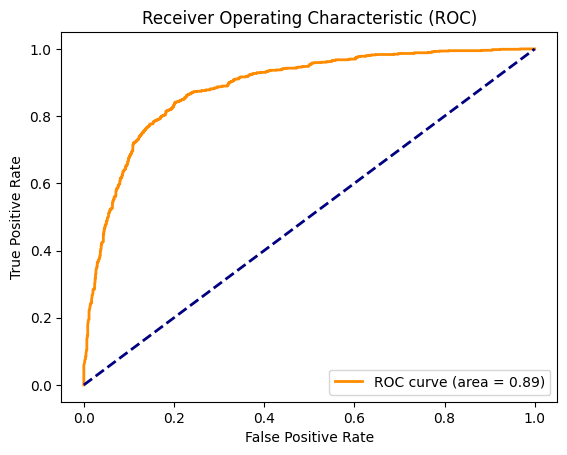

In [16]:
from sklearn.metrics import confusion_matrix, roc_curve, auc

# Get predictions
y_pred_prob = model_lstm.predict(X_test_seq).ravel()
y_pred = (y_pred_prob > 0.5).astype(int)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('LSTM Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()